In [17]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

root_pth = "/mnt/ExtraDisk/wcx/research/FrequencyDiffusion"
all_data_pth = [
    "dataset/MFRED_clean.csv",
    # "ETT-small/ETTh1.csv",
    # "ETT-small/ETTh2.csv",
    # "ETT-small/ETTm1.csv",
    # "ETT-small/ETTm2.csv",
    # 'exchange_rate/exchange_rate.csv',
    # 'illness/national_illness.csv',
    # 'weather/weather.csv',
]
for data_pth in all_data_pth:
    df = pd.read_csv(os.path.join(root_pth, data_pth), index_col=0, parse_dates=True)[['value','t2m']]
    df = df.rename(columns={'value':'OT'})
    n_timestep = len(df)
    num_train = int(n_timestep * 0.7)
    scaler = StandardScaler()
    scaler.fit(df[:num_train])
    df[df.columns] = scaler.transform(df)
    df.index = pd.date_range('2019-01-01', periods=len(df), freq='5min')
        
    df.to_csv(os.path.join(root_pth, 'MFRED_scaled.csv'))
    long_df = []
    for c in df.columns.tolist():
        temp_df = df[[c]].copy()
        temp_df['unique_id'] = c
        temp_df = temp_df.reset_index()
        temp_df = temp_df.rename(columns={c:'y','date':'ds'})
        if data_pth.__contains__('ETTh'):
            num_train = 12 * 30 * 24
            num_test = 4 * 30 * 24
            num_vali = 4 * 30 * 24
            temp_df = temp_df[:num_train+num_vali+num_test]
        elif data_pth.__contains__('ETTm'):
            num_train = 12 * 30 * 24 * 4
            num_test = 4 * 30 * 24 * 4
            num_vali = 4 * 30 * 24 * 4
            temp_df = temp_df[:num_train+num_vali+num_test]
        long_df.append(temp_df)
    long_df = pd.concat(long_df)
    long_df = long_df.reset_index(drop=True)
    long_df.to_csv(os.path.join(root_pth, data_pth[:-4]+'_NF.csv'), index=False)
    # break

In [24]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon, LongHorizonInfo
import logging
import os
import argparse
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import (
    NHITS,
    DLinear,
    PatchTST,
    TimesNet,
    # iTransformer,
    # TFT,
    Autoformer,
    # FEDformer,
    # LSTM,
    # MLP,
    # NBEATSx,
    # DeepAR,
)
from neuralforecast.losses.numpy import mse, mae
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.losses.numpy import mqloss, mse, mae
from src.utils.metrics import calculate_metrics, get_bench_metrics
import pickle

# Change this to your own data to try the model
print(LongHorizonInfo['ECL'].test_size)
Y_df, _, _ = LongHorizon.load(directory='/home/user/data/NF_longterm', group='ECL')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 960 timestamps as validation and test
n_time = len(Y_df.ds.unique())
num_train = int(n_time * 0.7)
num_test = int(n_time * 0.2)
print(num_test)
num_vali = n_time - num_train - num_test
# num_train = 12 * 30 * 24
# num_test = 4 * 30 * 24
# num_vali = 4 * 30 * 24
        
# val_size = 96*10
# test_size = 96*10

Y_df = Y_df[Y_df['unique_id'] == 'OT']


5260
5260


In [17]:
y_true = Y_hat_df["y"].values.reshape(-1, pred_len, 1)
print(y_true.shape)
y_true[0][:10]

(5069, 192, 1)


array([[-0.61717031],
       [-0.78310749],
       [-0.90936403],
       [-1.13662581],
       [-1.20516508],
       [-1.21057607],
       [-1.32601063],
       [-1.47210749],
       [-1.63083   ],
       [-1.45226717]])

In [ ]:
# SAVE METRICS
ds = [
    "ETTh1",
    "ETTh2",
    "ETTm1",
    "ETTm2",
    "ECL",
    "Exchange",
    "TrafficL",
    "Weather",
]
pred_len = [96, 192, 336, 720]
save_dir = "/mnt/ExtraDisk/wcx/research/benchmarks"
all_df = []
for d in ds:
    ds_df = []
    for pl in pred_len:
        result_path = os.path.join(save_dir, f"{d}_96_{pl}_U","results.csv")
        df = pd.read_csv(result_path, index_col=0)
        df.index.name = 'model'
        df = df.reset_index()
        df = df.groupby('model').mean()
        df = df.drop(columns=['MAE', 'iter'])
        df = df.stack()
        df = pd.DataFrame(df, columns=[pl]).transpose()
        ds_df.append(df)
    ds_df = pd.concat(ds_df)
    ds_df.index.name = 'pred_len'
    ds_df['dataset'] = d
    ds_df = ds_df.reset_index()
    ds_df = ds_df.set_index(['dataset','pred_len'])
    all_df.append(ds_df)
all_df = pd.concat(all_df)
all_df.to_csv(os.path.join(save_dir, 'bench_result.csv'))
# print(all_df.to_latex(float_format="{:.3f}".format))

In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
# SAVE METRICS
ds = [
    # "ETTh1",
    # "ETTh2",
    # "ETTm1",
    # "ETTm2",
    # "ECL",
    # "Exchange",
    # "TrafficL",
    # "Weather",
    "MFRED"
]
# pred_len = [96, 192, 336, 720]
pred_len = [288, 432, 576]
save_dir = "/mnt/ExtraDisk/wcx/research/benchmarks"
all_df = []
for d in ds:
    ds_df = []
    for pl in pred_len:
        result_path = os.path.join(save_dir, f"{d}_288_{pl}_U","true.npy")
        y_real = np.load(result_path)
        print(y_real.shape)
        print(y_real.flatten()[:10])
        break
    break

(20737, 288, 1)
[-0.93986556 -1.03647613 -1.09602095 -1.1134468  -1.15728492 -1.07101525
 -1.20393617 -1.23112987 -1.23310949 -1.24470067]


In [32]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


ds = {
        "ETTh1": "ETTh1",
        "ETTh2": "ETTh2",
        "ETTm1": "ETTm1",
        "ETTm2": "ETTm2",
        "ECL": "electricity",
        "Exchange": "exchange_rate",
        "TrafficL": "traffic",
        "Weather": "weather",
        "MFRED": "mfred",
    }

for d in ds:
    print(d)
    if d=='Weather':
        data_dir_nf = '/mnt/ExtraDisk/wcx/research'
        dataset_nf = d
        data_dir_thu = '/mnt/ExtraDisk/wcx/research/THU-timeseries'
        dataset_thu = f"{'ETT-small' if ds[d].__contains__('ETT') else ds[d]}/{ds[d]}.csv"
        csv_thu = os.path.join(data_dir_thu, dataset_thu)
        
        # THU
        df_thu = pd.read_csv(csv_thu, index_col=0, parse_dates=True)[['OT']]
        if d.__contains__("ETTh"):
            num_train = 12 * 30 * 24
            # num_test = 4 * 30 * 24
            # num_vali = 4 * 30 * 24
        elif d.__contains__("ETTm"):
            num_train = 12 * 30 * 24 * 4
            # num_test = 4 * 30 * 24 * 4
            # num_vali = 4 * 30 * 24 * 4
        else:
            num_train = int(len(df_thu) * 0.7)
            # num_test = int(len(Y_df) * 0.2)
            # num_vali = len(Y_df) - num_train - num_test
        scaler = StandardScaler()
        scaler.fit(df_thu.values[:num_train])
        df_thu_value = scaler.transform(df_thu.values)
        
            
        # NF
        Y_df, _, _ = LongHorizon.load(directory=data_dir_nf, group=dataset_nf)
        Y_df["ds"] = pd.to_datetime(Y_df["ds"])
        df_nf = Y_df[Y_df["unique_id"] == "OT"]
        df_nf = df_nf.drop(columns=['unique_id'])
        df_nf = df_nf.set_index('ds')
        
        if df_thu_value.shape != df_nf.values.shape:
            print("shape is not the same")
            print(f'{d}')
            print(df_thu_value.shape)
            print(df_nf.values.shape)
            max_len = min(len(df_thu_value), len(df_nf.values))
        else:
            max_len = len(df_thu_value)
        
        close = np.allclose(df_thu_value.flatten()[:max_len], df_nf.values.flatten()[:max_len])
        close = np.allclose(df_thu_value.flatten()[-10000:], df_nf.values.flatten()[-10000:])
        print(close)
        if not close:
            # plt.plot(df_thu_value.flatten()[-10000:])
            # plt.plot(df_nf.values.flatten()[-10000:])
            plt.scatter(df_thu_value.flatten()[-10000:], df_nf.values.flatten()[-10000:])
        print('----'*10)
    # fig, ax = plt.subplots()
    # ax.scatter(df_thu_value.flatten()[:max_len], df_nf.values.flatten()[:max_len])
    
    
    



ETTh1
ETTh2
ETTm1
ETTm2
ECL
Exchange
TrafficL
Weather
shape is not the same
Weather
(52696, 1)
(52695, 1)
True
----------------------------------------


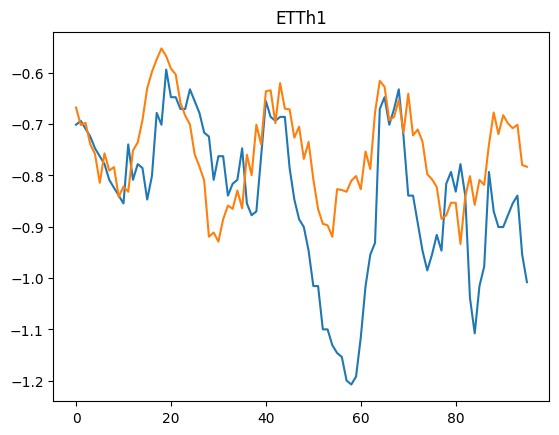

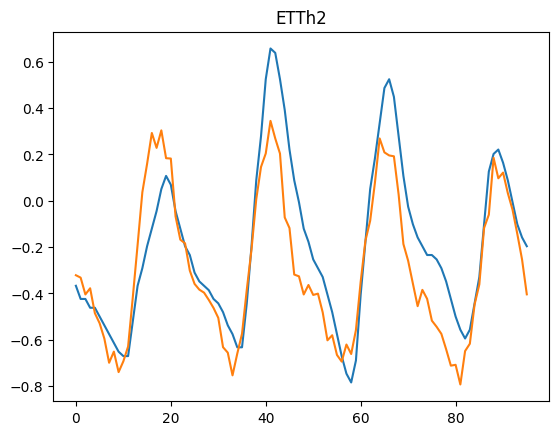

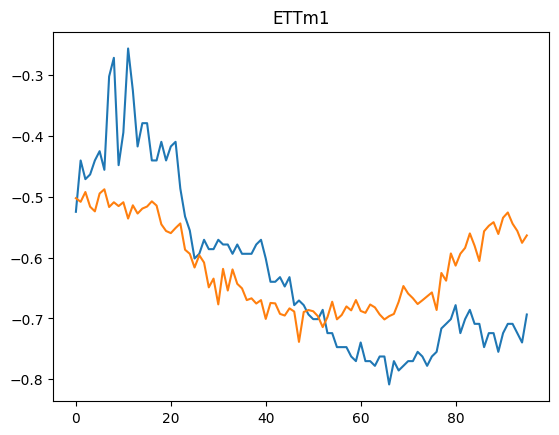

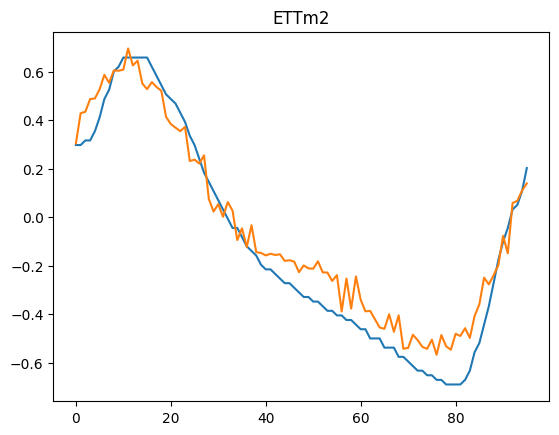

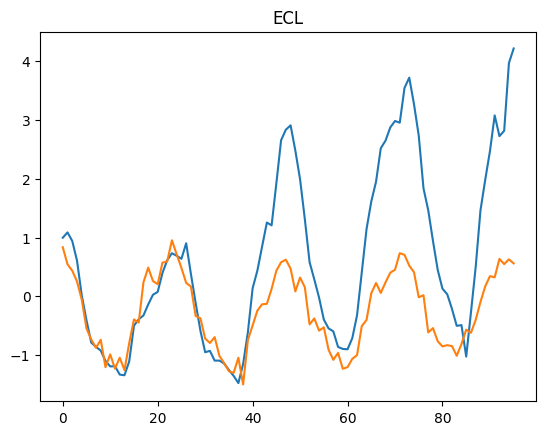

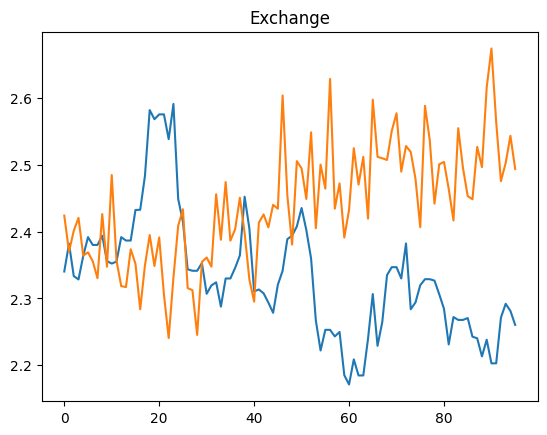

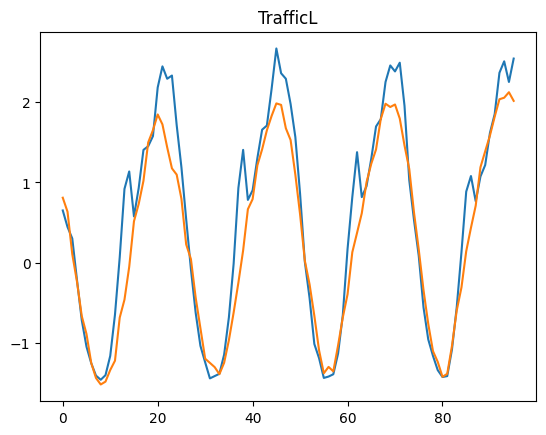

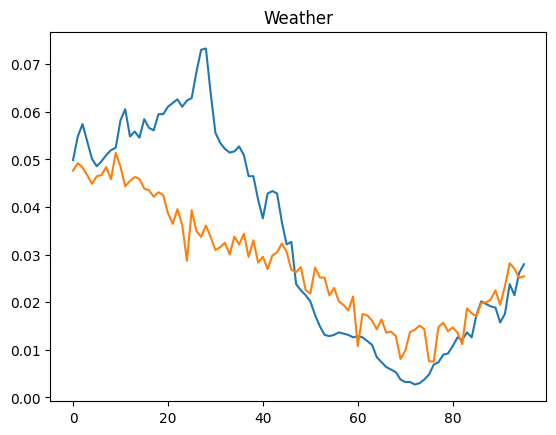

In [3]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from neuralforecast.losses.numpy import mse, mqloss
# # SAVE METRICS
ds = [
    "ETTh1",
    "ETTh2",
    "ETTm1",
    "ETTm2",
    "ECL",
    "Exchange",
    "TrafficL",
    "Weather",
]
quantiles=[0.05 * i for i in range(19)]
# pred_len = [336]
pred_len = [96, 192, 336, 720]
save_dir = "/mnt/ExtraDisk/wcx/research/benchmarks"
all_df = []
for d in ds:
    # if d != 'TrafficL':
    #     continue
    ds_df = []
    for pl in pred_len:
        label_path = os.path.join(save_dir, f"{d}_96_{pl}_U","true.npy")
        pred_path = os.path.join(save_dir, f"{d}_96_{pl}_U","pred_PatchTST_0.npy")
        y_true = np.load(label_path)
        y_pred = np.load(pred_path)
        # y_true = y_true[::pl].flatten()
        fig, ax = plt.subplots()
        ax.plot(y_true[333].flatten())
        ax.plot(y_pred[333, ..., 9].flatten())
        
        ax.set_title(d)
        # plt.plot(y_true[126].flatten())
        # plt.plot(y_pred[126, ..., 9].flatten())
        break
    # break
#         df.index.name = 'model'
#         df = df.reset_index()
#         df = df.groupby('model').mean()
#         df = df.drop(columns=['MAE', 'iter'])
#         df = df.stack()
#         df = pd.DataFrame(df, columns=[pl]).transpose()
#         ds_df.append(df)
#     ds_df = pd.concat(ds_df)
#     ds_df.index.name = 'pred_len'
#     ds_df['dataset'] = d
#     ds_df = ds_df.reset_index()
#     ds_df = ds_df.set_index(['dataset','pred_len'])
#     all_df.append(ds_df)
# all_df = pd.concat(all_df)
# all_df.to_csv(os.path.join(save_dir, 'bench_result.csv'))
# print(all_df.to_latex(float_format="{:.3f}".format))

In [10]:
import torch
ds = {
#         "ETTh1": "etth1",
#         "ETTh2": "etth2",
#         "ETTm1": "ettm1",
#         "ETTm2": "ettm2",
#         "ECL": "electricity",
#         "Exchange": "exchange_rate",
#         "TrafficL": "traffic",
#         "Weather": "weather",
        "MFRED": "mfred",
    }
pred_len = [288, 432, 576]
# pred_len = [96, 192, 336, 720]
save_dir = "/mnt/ExtraDisk/wcx/research/FrequencyDiffusion/savings"
all_df = []
for d in ds:
    real_d = ds[d]
    ds_df = []
    for pl in pred_len:
        result_path = os.path.join(save_dir,f"{real_d}_{pl}_S", "test_dl.pt")
        test_dl = torch.load(result_path)
        y_real = []
        for b in test_dl:
            y_real.append(b['future_data'].cpu().numpy())
        y_real = np.concatenate(y_real)
        print(d, pl)
        print(y_real.shape)
        print(y_real.flatten()[-10:])
        break

MFRED 288
(20737, 288, 1)
[-0.3392078  -0.2893006  -0.30688274 -0.35564384 -0.41281834 -0.36687037
 -0.40888515 -0.46277764 -0.49096116 -0.4871582 ]


In [ ]:
import pandas as pd
